# Time Series Clustering


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA, IncrementalPCA

import datetime
import matplotlib.dates as mdates

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")

In [2]:
# set global ploting params
font = {'family' : 'serif',
        'weight' : 'normal',
        'size' : 14}

plt.rc('font', **font)

In [3]:
ls ../data/

 babynames.dat           'top1000_@.dat'      top_divergence_10.txt
 babynames_top10002.dat   top1000_#.dat       top_divergence_20.txt
 babynames_top10002.txt  'top1000_no@#.dat'   top_divergence_5.csv
 babynames.txt           'top1000_no@#.txt'   top_divergence_5.dat
 elbow/                  'top1000_@.txt'      top_divergence_5.txt
 names/                   top1000_#.txt


# Load dataset:
Choose a filename from above without an extention

In [4]:
filename = 'top1000_no@#'

x = np.loadtxt(f'../data/{filename}.dat')
with open(f'../data/{filename}.txt','r') as f:
    names = [i.strip() for i in f.readlines()]
print(names)

names = np.array(names)
dates = pd.date_range(start=datetime.datetime(2008,9,9),end=datetime.datetime(2019,9,3),freq='D')

['140727', 'แค', '조심히', '結果はこちら', 'each', 'coding', '完全流出動画', '180930', 'cess', 'myxitup', 'ayuda', 'crown', 'کے', '//4sq', '토토', 'rake', 'newton', 'envoyer', 'kamu', '번째', '머스터', 'colegio', '아미', 'sitesi', "o'reilly", 'gezi', 'anything', 'co/4kghkzdqzh', 'sprouse', '180529', 'emotionally', 'homage', 'influenza', 'chinese', 'お得なコンビ', "nite's", 'years', 'ni', 'japon', 'eurovision', 'بشكل', 'oned', 'mv', 'qué', 'marcha', '받아요', 'sager', 'forum', '投票可能', 'ณล', 'carolina', 'ciudad', '160928', 'vids', '명품카지노', 'lista', 'caravan', 'bbr', 'hologram', 'عندك', 'msnbc', 'corinthiana', 'برحمتك', 'なんとオーブ50個ゲット', 'kapamilya', '配布されるアイテムは毎日変わるよ', '151125', 'summertime', 'shopgirl', 'rate', 'kizlarla', '8-bit', 'bonuses', 'ういーっす', 'walang', 'hussle', 'マジうまっ', 'purposejustinbieber', '160322', 'chorão', 'bataclan', 'strong', 'ly/yqlpa', 'ะ', '今回はハズレです', 'innovate', 'domingo', 'adium', 'lovatos', 'incamiguinwithlove', 'server', 'นเท', 'yaaa', 'ﾟдﾟ', 'ᕗ', 'mt', 'bacana', 'hank', 'ல', '그래미', 'fucked', '女子

In [5]:
print(f"Data's min: {np.min(x)}")
print(f"Data's non-zero min: {np.min(x[np.nonzero(x)])}")

print(f"Data's max: {np.max(x)}")

Data's min: 0.0
Data's non-zero min: 1.3696795535656601e-08
Data's max: 0.051449055186822794


# Preprocessing

We're going to log transform our data since the usage rate spans 7 orders of magnitude. We add a small value to avoid taking the log of zero.

In [25]:
x1 = np.log10(x+(10**(-8)/2))
print(x1.shape)

(21267, 4012)


# PCA

In [7]:
pca = PCA()

# Compute PCA for our dataset
obs_trans_ = pca.fit_transform(x1)


In [8]:
# Transform our data into the lower dimensional space
transform = pca.transform(x1)

# Plotting PCA Eigenfunctions

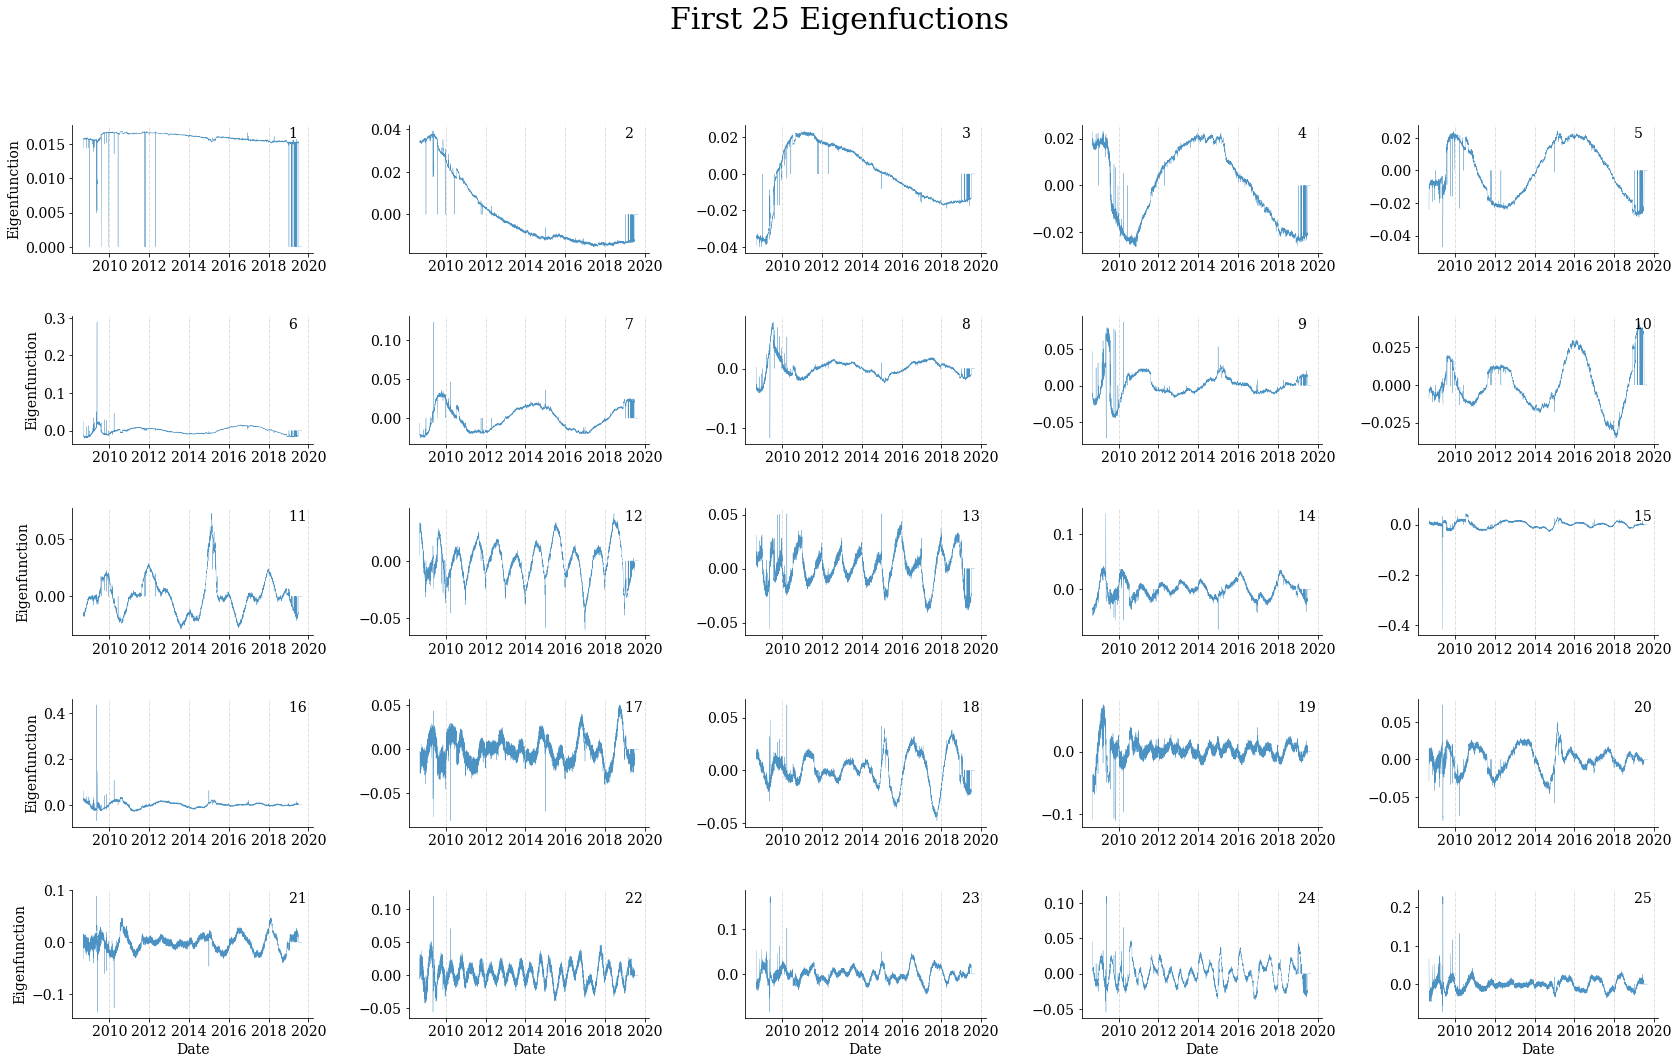

In [9]:
def plot_eigenfunctions(dates, eigen, axs):
    axs.plot(dates,eigen,lw=0.3, alpha=0.8)
    
plt.figure(figsize=(36*1.5/1.9,24*1.3/1.9))
n = 5


gs0s = ['gs'+str(i)+str(j) for i in range(n) for j in range(n)]

gs0 = gridspec.GridSpec(n, n)

miny,maxy = 1,1
for i in range(n*n):
    gs0s[i] = plt.subplot(gs0[i])
    plt.subplots_adjust(wspace=0.4,hspace=0.5)
    plot_eigenfunctions(dates,pca.components_[i],gs0s[i])

for i, axs in enumerate(gs0s):
    #axs.set_yticklabels([i for i in axs.get_yticklabels()])
    if i >= n*n-n:
        axs.set_xlabel('Date')
    if i%n ==0:
        axs.set_ylabel("Eigenfunction")
    axs.text( 0.9, 0.9, f"{i+1} ",
            transform = axs.transAxes)
        
    axs.grid(which='major', axis='x',lw=1,linestyle='--',alpha=0.4)
    axs.spines['right'].set_visible(False)

    axs.spines['top'].set_visible(False)
plt.savefig(f"../figures/{filename}.pdf")
plt.savefig(f"../figures/{filename}.png", transparent=True)
plt.suptitle("First 25 Eigenfuctions", fontsize=30)

plt.show()

# PCA data compression/ reconstruction

In [10]:
def plot_components(x_t, dates, pca, n_list ,name):
    """Plot showing first n components of the word"""
    if type(n_list) is int:
        n_list = list(n_list)
    
    plt.figure(figsize=(8,6),dpi=200)
    for n in n_list:
        x_transform = pca.transform(x_t.reshape(1, -1))[0]
        y_t = np.dot(x_transform[:n],pca.components_[:n])+pca.mean_
        
        label = "$\hat{X}_{"+str(n)+"}$"
        plt.plot(dates, y_t,lw=1,label=label)
        
    plt.plot(dates, x_t,lw=1,label="$X_t$")
    plt.legend()
    plt.ylabel("Log_10 realative frequency")
    plt.xlabel("Date")
    plt.ylim(-9,-1)
    plt.title(f"PCA reconstruction: '{name}'", fontsize=20)
    plt.show()
    
def plot_component_differences(x_t, dates, pca, n_list ,name):
    """Plot showing first n components of the word"""
    if type(n_list) is int:
        n_list = list(n_list)
    
    plt.figure(figsize=(8,6), dpi=200)
    for n in n_list:
        x_transform = pca.transform(x_t.reshape(1, -1))[0]
        y_t = np.dot(x_transform[:n],pca.components_[:n])+pca.mean_
        
        label = "$\hat{X}_{"+str(n)+"}$"
        plt.plot(dates, y_t-x_t,lw=1,label=label)
        
    plt.legend()
    plt.ylabel("$\Delta (\log_{10})$ relative frequency$")
    plt.xlabel("Date")
    plt.title("Differences: '"+name + "'", fontsize=20)
    plt.show()
    
def transition(x_t, pca, name):
    n_list = [i for i in range(1,1000,2)]
    data = []
    for n in n_list:
        x_transform = pca.transform(x_t.reshape(1, -1))[0]
        y_t = np.dot(x_transform[:n],pca.components_[:n])+pca.mean_
        data.append(np.sum(np.abs(y_t-x_t)))

    plt.semilogy(n_list, data, lw=1,label=name)

    plt.ylabel('$\sum \Delta$', fontsize=15)
    plt.xlabel("# components", fontsize=15)
    plt.title("Recontruction Error", fontsize=20)
    plt.legend()

    
def transition_diff(x_t, pca, name):
    n_list = [i for i in range(1,1000,2)]
    data = []
    for n in n_list:
        x_transform = pca.transform(x_t.reshape(1, -1))[0]
        y_t = np.dot(x_transform[:n],pca.components_[:n])+pca.mean_
        data.append(np.sum(np.abs(y_t-x_t)))

    plt.semilogy(n_list[:-1], np.diff(-data), lw=1,label=name)

    plt.ylabel('$\sum \Delta$')
    plt.xlabel("# components")
    plt.legend()

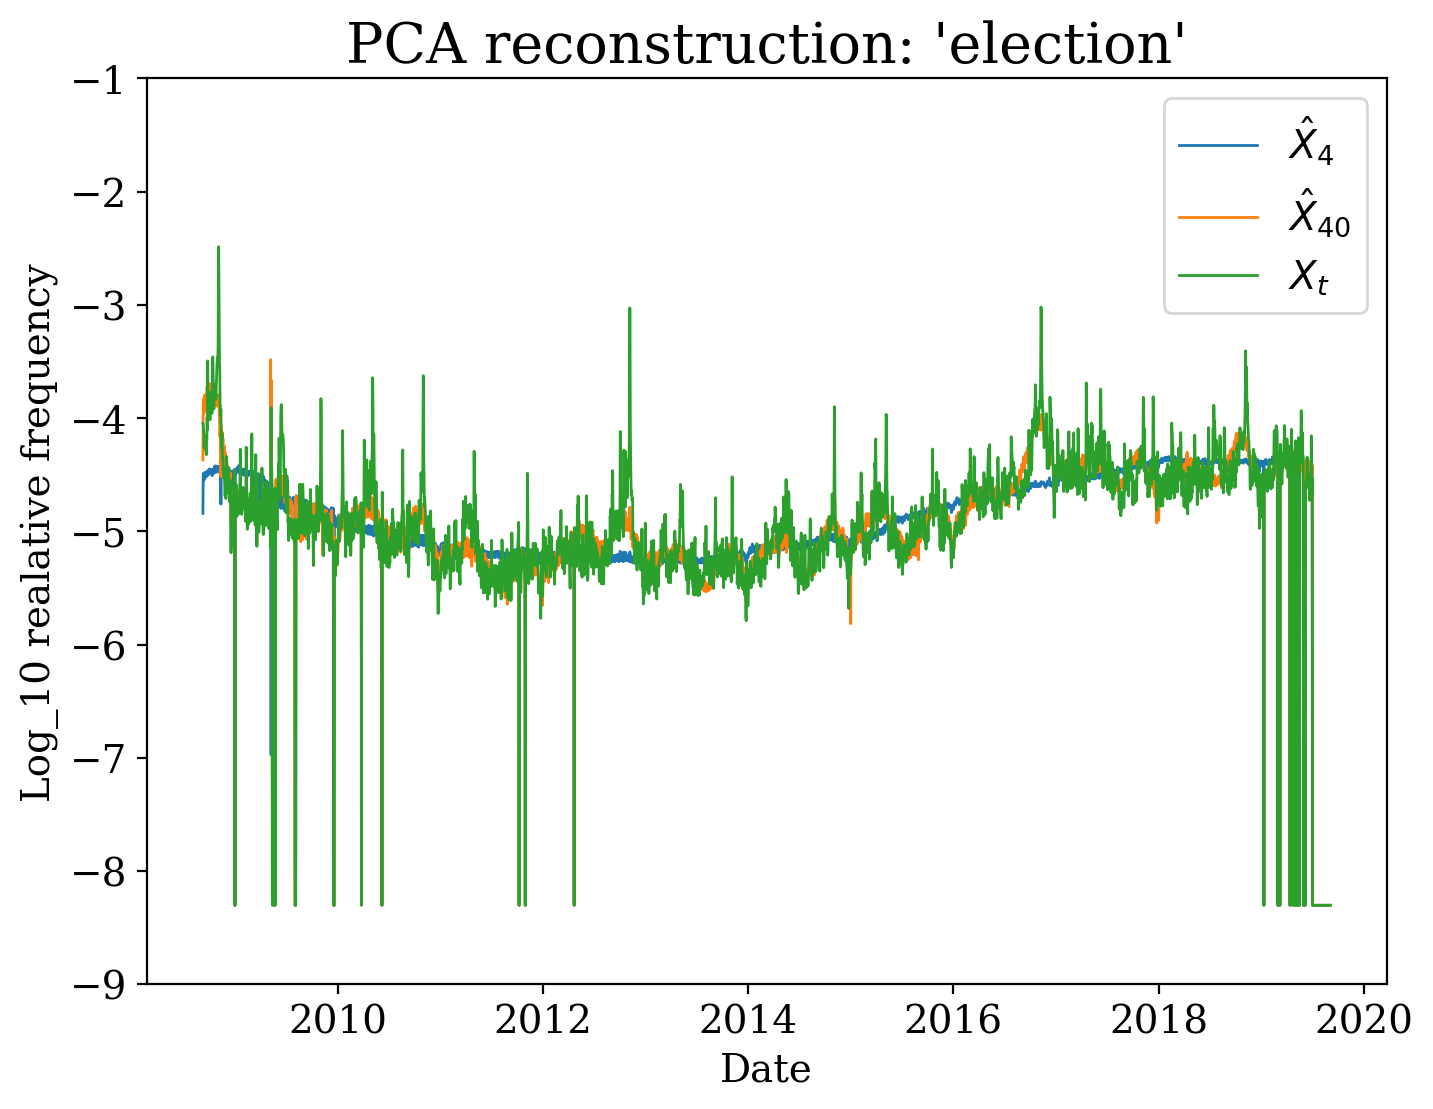

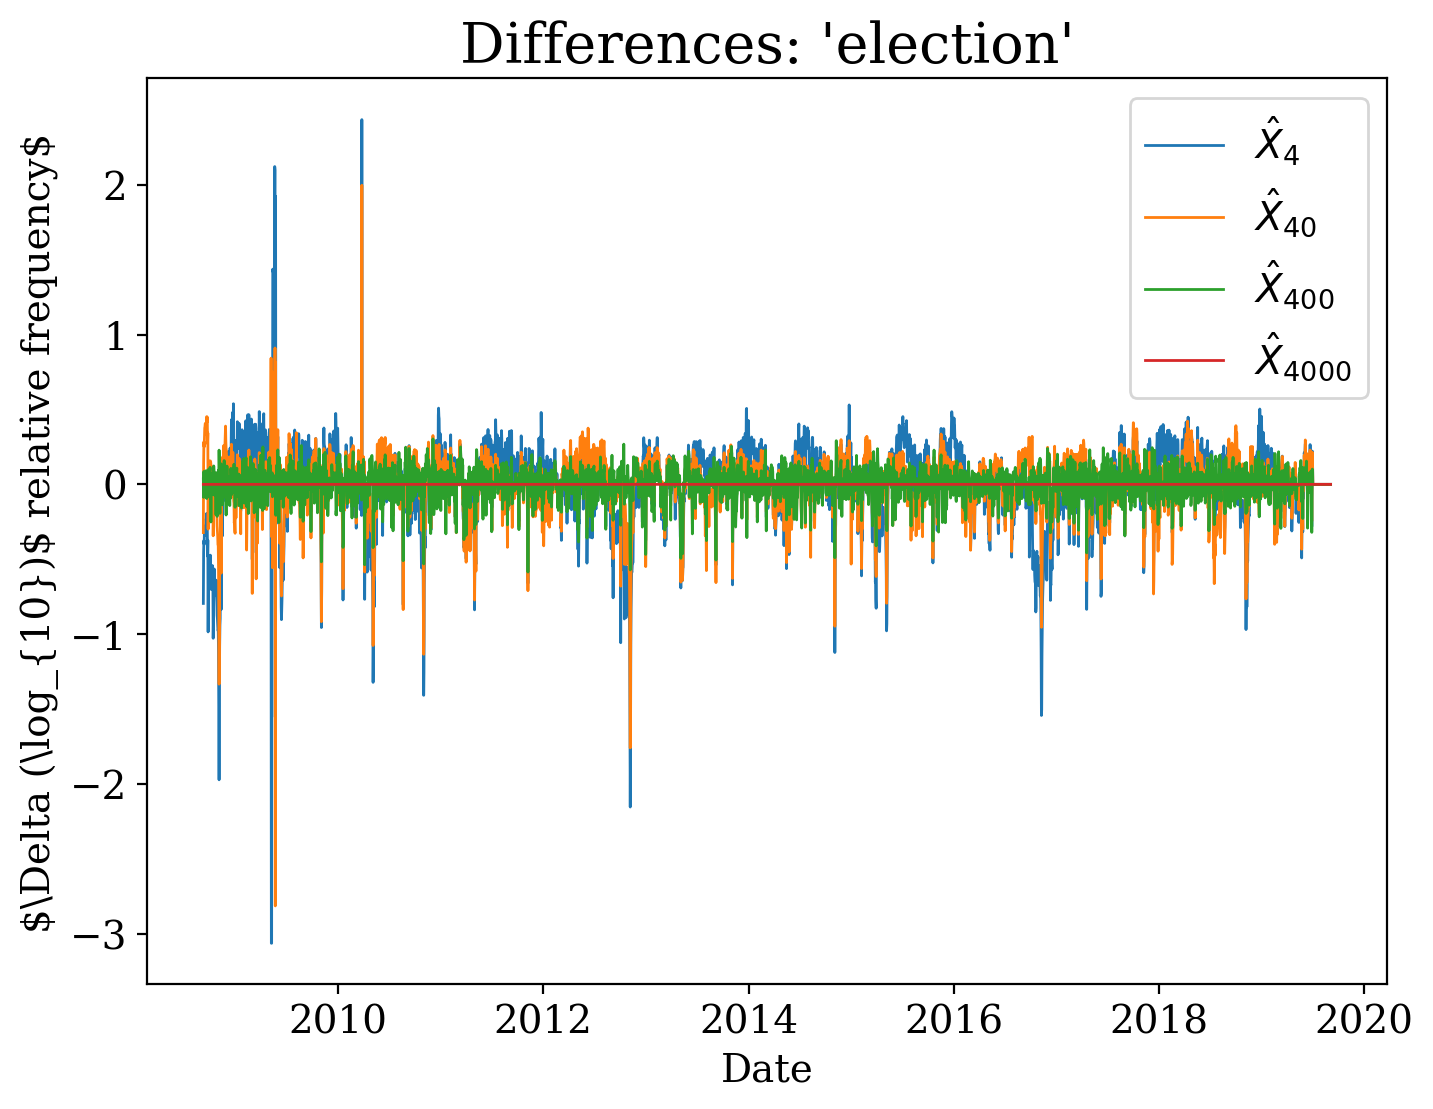

[-4.04631023 -4.05791155 -4.10994791 ... -8.30103    -8.30103
 -8.30103   ]


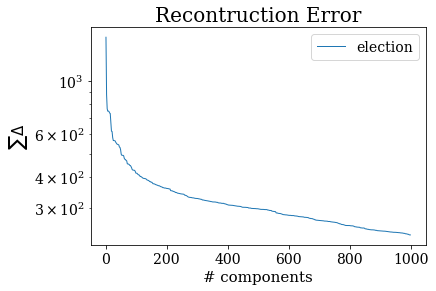

In [11]:
word = 'election'
x_t = x1[names==word][0]

plot_components(x_t, dates, pca, [4,40],word)
plot_component_differences(x_t, dates, pca, [4,40,400,4000],word)
transition(x_t,pca,word)
print(x_t)

# K Means Clustering

Our first clustering technique is kmeans. We try to find clusters on the data reconstructed from the first 40 PCA components.

In [58]:
n_clusters = 3
kmeanModel = KMeans(n_clusters=n_clusters,n_jobs=40).fit(obs_trans_)
print('clustering ...')
kmeanModel.fit(obs_trans_)
print('finished.')
min_dist = np.min(cdist(obs_trans_, kmeanModel.cluster_centers_, 'euclidean'), axis=1)
print(min_dist)
print(min_dist.shape)

clustering ...
finished.
[27.44752748 44.33767702 34.48469855 ... 53.071552   35.78710909
 37.85159464]
(21267,)


clustering: k = 1 -- 5.0%
clustering: k = 2 -- 10.0%
clustering: k = 3 -- 15.0%
clustering: k = 4 -- 20.0%
clustering: k = 5 -- 25.0%
clustering: k = 6 -- 30.0%
clustering: k = 7 -- 35.0%
clustering: k = 8 -- 40.0%
clustering: k = 9 -- 45.0%
clustering: k = 10 -- 50.0%
clustering: k = 11 -- 55.0%
clustering: k = 12 -- 60.0%
clustering: k = 13 -- 65.0%
clustering: k = 14 -- 70.0%
clustering: k = 15 -- 75.0%
clustering: k = 16 -- 80.0%
clustering: k = 17 -- 85.0%
clustering: k = 18 -- 90.0%
clustering: k = 19 -- 95.0%


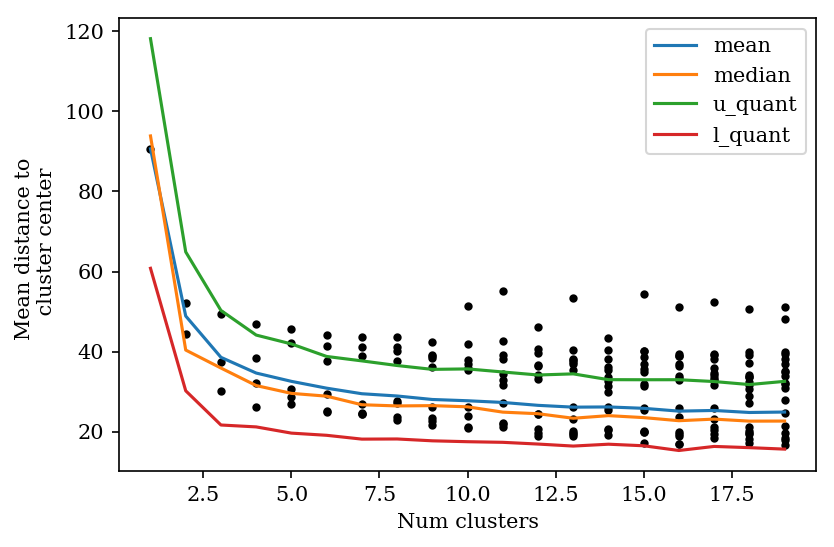

In [70]:
plt.figure(figsize=(6,4), dpi=150)
mean_line = []
median_line = []
u_quant = []
l_quant = []

num_eigen = 100

max_means = 20
cluster_variance = []
for n_clusters in range(1,max_means):
    kmeanModel = MiniBatchKMeans(n_clusters=n_clusters).fit(obs_trans_[:,:num_eigen])
    print(f'clustering: k = {n_clusters} -- {100*n_clusters/max_means:0.1f}%')
    kmeanModel.fit(obs_trans_)
    min_dist = np.min(cdist(obs_trans_, kmeanModel.cluster_centers_, 'euclidean'), axis=1)

    for i in range(n_clusters):
        plt.plot(n_clusters,sum(min_dist[kmeanModel.labels_ == i])/sum(kmeanModel.labels_ == i),'ko',ms=3)
        cluster_variance.append([n_clusters,sum(min_dist[kmeanModel.labels_ == i])/sum(kmeanModel.labels_ == i)])
    mean_line.append(sum(min_dist)/obs_trans_.shape[0])
    median_line.append(np.median(min_dist))
    u_quant.append(np.quantile(min_dist,0.75))
    l_quant.append(np.quantile(min_dist,0.25))
plt.plot([i for i in range(1,max_means)],mean_line,label='mean')
plt.plot([i for i in range(1,max_means)],median_line,label='median')
plt.plot([i for i in range(1,max_means)],u_quant,label='u_quant')
plt.plot([i for i in range(1,max_means)],l_quant,label='l_quant')

plt.title('')
plt.ylabel("Mean distance to \n cluster center")
plt.xlabel("Num clusters")
plt.legend()

In [12]:
def plot_wraper(x1, word_list, fourier=False):
    if fourier:
        fig,axs = plt.subplots(2,1, figsize=(14,14*2/4))
        
        for i, word_i in enumerate(word_list):
            plot_fourier(x1[names==word_i][0], word_i, dates, axs,i)
        # More Plot formatting
        axs[0].set_ylabel('Frequency')
        axs[0].grid(which='major', axis='x')
        axs[1].set_ylim((10**(-6),10**(-1)))
        for i in range(2):
            axs[i].spines['right'].set_visible(False)
            axs[i].spines['left'].set_visible(False)
            axs[i].grid(which='major', axis='x',lw=0.5,alpha=0.3,linestyle='--')
            axs[i].grid(which='minor', axis='x',lw=0.5,alpha=0.3,linestyle='--')
            axs[i].minorticks_on()
            axs[i].legend(prop={'size': 12});

        plt.tight_layout()
        plt.show()
    else:
        fig,axs = plt.subplots(1,1, figsize=(14,14*2/8))
        for i, word_i in enumerate(word_list):

            axs.plot(dates, x1[names==word_i][0], ',',ms=5,color=colors[i%len(colors)])
            axs.plot(dates, x1[names==word_i][0],lw=0.5,alpha=0.2,color=colors[i%len(colors)], label=f'{word_i}')

        axs.legend()
        axs.set_ylabel('Frequency')
        axs.grid(which='major', axis='x')
        axs.spines['right'].set_visible(False)
        axs.spines['left'].set_visible(False)
        axs.grid(which='major', axis='x',lw=0.5,alpha=0.3,linestyle='--')
        axs.grid(which='minor', axis='x',lw=0.5,alpha=0.3,linestyle='--')
        axs.minorticks_on()
        axs.legend(prop={'size': 12});

        plt.tight_layout()
        plt.show()
    print(word_list)

In [16]:
colors = '#92576A,#876C8D,#6984A2,#499BA3,#4CAD91,#79B974,#B4BF5D,#F2BE5D'.split(',')
clusters = 4
num_eigen = 10
# train Kmeans with compressed data
kmeanModel = KMeans(n_clusters=clusters,n_jobs=40).fit(obs_trans_[:,:num_eigen])
neigh = NearestNeighbors(5,1)
neigh.fit(obs_trans_[:,:num_eigen])

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1)

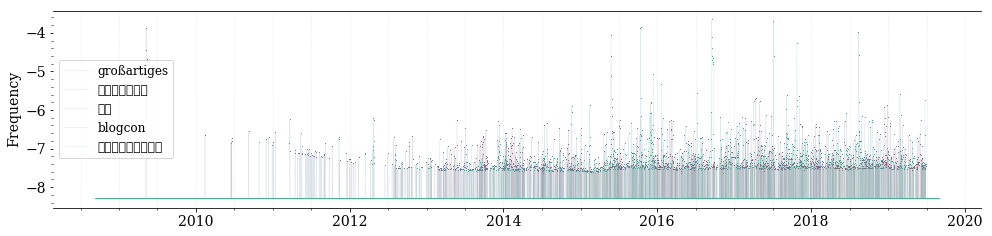

['großartiges', 'องคนไหน', '左足', 'blogcon', 'チャンピオンシップ']


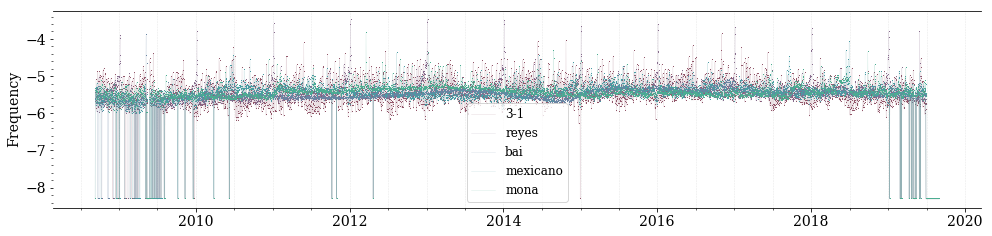

['3-1', 'reyes', 'bai', 'mexicano', 'mona']


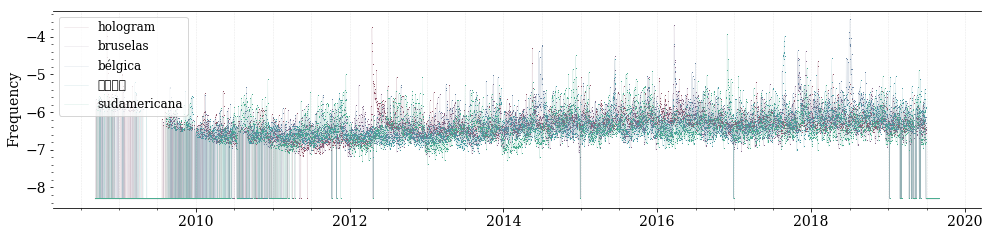

['hologram', 'bruselas', 'bélgica', 'เกมส', 'sudamericana']


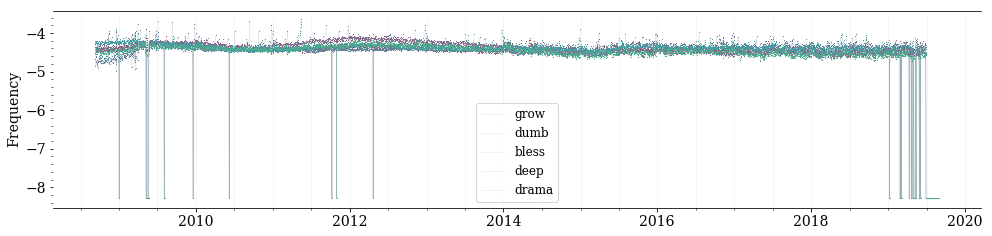

['grow', 'dumb', 'bless', 'deep', 'drama']


In [17]:
closest = neigh.kneighbors(kmeanModel.cluster_centers_[:,:num_eigen], 5, return_distance=False)

for i in closest:
    plot_wraper(x1,[names[j] for j in i])
    

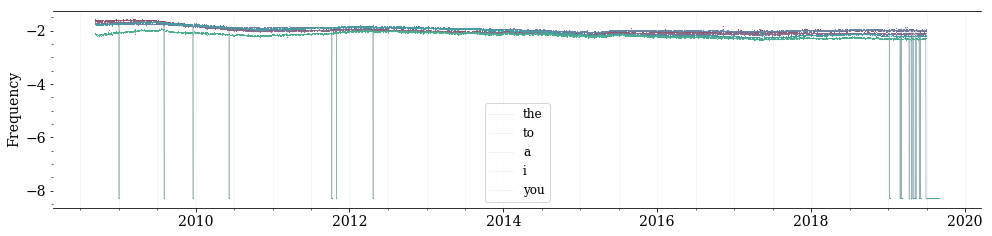

['the', 'to', 'a', 'i', 'you']


In [24]:
word_i = 'the'
num_neighbors = 5
coefficients = pca.transform(x1[names==word_i][:,:])
closest = neigh.kneighbors(coefficients[:,:num_eigen], num_neighbors, return_distance=False)

for i in closest:
    plot_wraper(x1,[names[j] for j in i])

# Dimensionality Reduction and Visualization

In [26]:
from sklearn.manifold import TSNE
num_eigen = 100

X_embedded = TSNE(n_components=2).fit_transform(obs_trans_[:,:num_eigen])

In [33]:
k=4
kmeanModel = MiniBatchKMeans(n_clusters=k).fit(obs_trans_[:,:num_eigen])

Text(0.5, 1.0, 'Timeseries in t-SNE Embedding\n K=4')

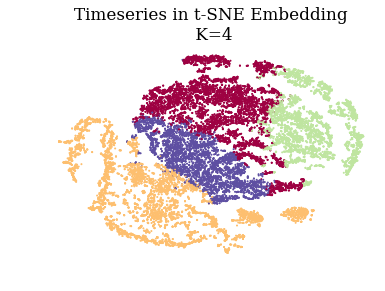

In [34]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=kmeanModel.labels_.ravel(),s=1, cmap=plt.cm.Spectral)
plt.axis('off')
plt.title(f"Timeseries in t-SNE Embedding\n K={k}")

In [35]:
np.savetxt('../clipboard/Y',X_embedded)
np.savetxt('../clipboard/names',names,fmt='%s')
np.savetxt('../clipboard/labels',kmeanModel.labels_.ravel())